## What is AdaBoost?

AdaBoost (Adaptive Boosting) is a powerful ensemble method that:

- Begins with uniform sample weights  
- Trains a weak learner (usually a decision stump)  
- Increases weights for misclassified points  
- Repeats the process, focusing on "hard" examples  
- Combines all weak learners into a final strong model using weighted voting  

The sample weights help the algorithm focus on difficult cases.

The core formula for updating weights:

$$
w_i \leftarrow w_i \cdot e^{- \alpha_t y_i h_t(x_i)}
$$

Where:

- $y_i \in \{-1, +1\}$ is the true label  
- $h_t(x_i) \in \{-1, +1\}$ is the prediction of the $t$-th weak learner  
- $\alpha_t = \frac{1}{2} \log\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$ is the weight for the weak learner  


---
## Imports and Data Setup

We use `make_moons` to generate a synthetic dataset, and convert labels to {-1, +1} for AdaBoost math.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier

# Generate dataset
X, y = make_moons(n_samples=50, noise=0.2, random_state=42)
y_signed = np.where(y == 0, -1, 1)

---
## Visualize Initial Data

Here we plot the initial dataset to see how the classes are distributed.


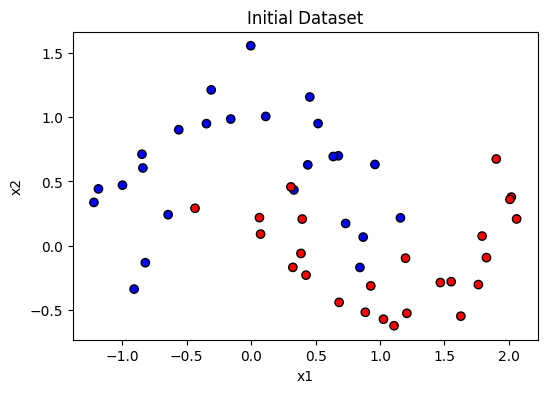

In [2]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("Initial Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

---
## Helper Functions

These functions help us visualize decision boundaries and weighted points.


In [ ]:
# -------------------------------
# Helper Functions for Visualization
# -------------------------------

# Convert sample weights to point sizes
def get_point_sizes(weights, min_size=20, max_size=100):
    norm_weights = weights / np.max(weights)
    sizes = norm_weights * (max_size - min_size) + min_size
    return sizes

# Plot data points with optional weights
def plot_data_with_weights(X, y, sample_weights, ax, title, use_weights=True):
    ax.set_title(title)
    if use_weights:
        sizes = get_point_sizes(sample_weights)
    else:
        sizes = np.full_like(y, 50)  # uniform size
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=sizes, edgecolors='k')
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

# Plot a single weak learner decision boundary
def plot_decision_boundary(model, X, y, ax, title, sample_weights, use_weights=True):
    plot_data_with_weights(X, y, sample_weights, ax, title, use_weights=use_weights)
    
    # Get exact axis limits after plotting points
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # High-resolution meshgrid matching axes
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict and reshape
    Z = model.predict(grid)
    Z_signed = np.where(Z == 0, -1, 1)
    Z_signed = Z_signed.reshape(xx.shape)
    
    # Plot decision regions
    ax.contourf(xx, yy, Z_signed, alpha=0.3, cmap=plt.cm.bwr, levels=[-1, 0, 1])

# Plot combined ensemble decision boundary
def plot_combined_boundary(models, alphas, X, y, t, ax, sample_weights, title, use_weights=True):
    # Plot points first to fix axes limits
    plot_data_with_weights(X, y, sample_weights, ax, title, use_weights=use_weights)
    
    # Get exact axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # High-resolution meshgrid matching axes
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute combined prediction
    final = np.zeros(len(grid))
    for i, model in enumerate(models):
        pred = model.predict(grid)
        pred_signed = np.where(pred == 0, -1, 1)
        final += alphas[i] * pred_signed

    combined_pred = np.where(final >= 0, 1, -1)
    
    # Plot decision regions
    ax.contourf(xx, yy, combined_pred.reshape(xx.shape), alpha=0.3, cmap=plt.cm.bwr, levels=[-1, 0, 1])

---
## AdaBoost Iterative Process

We train 3 weak learners. In each iteration, we visualize:

1. The dataset **before training**, with current sample weights  
2. The decision boundary of the **current weak learner (stump)**  
3. The **combined model** so far using all weak learners up to this point  


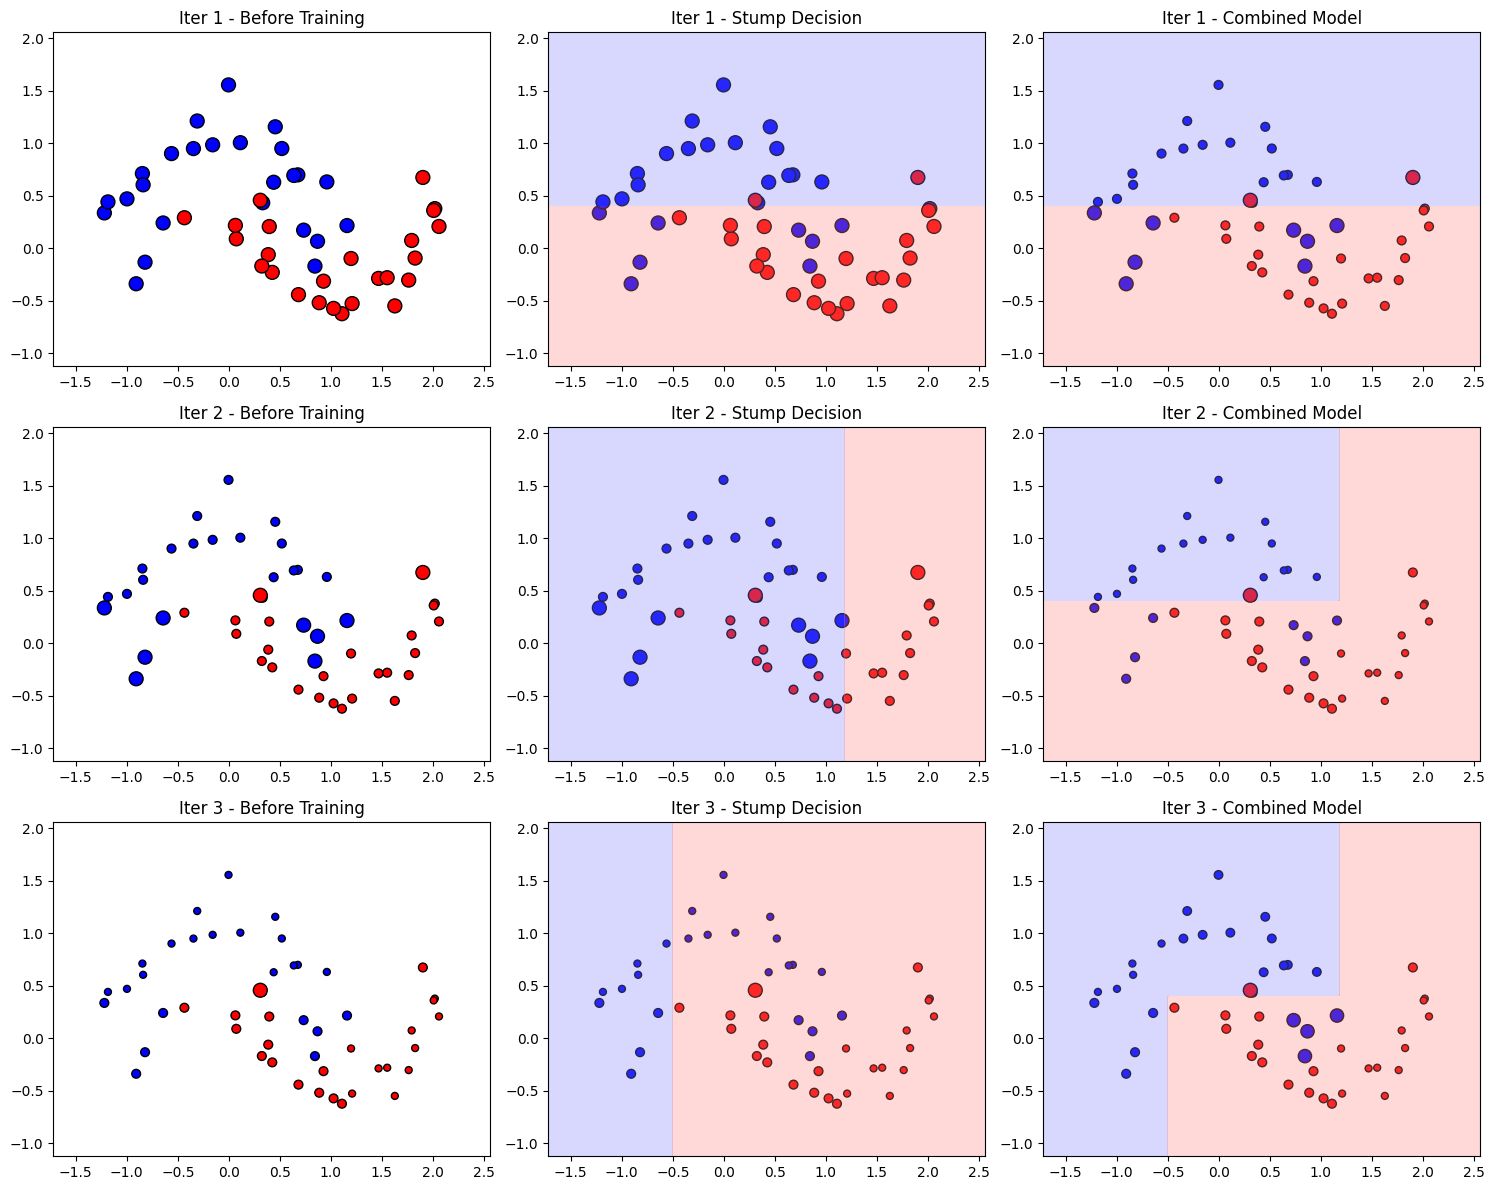

In [8]:
n_estimators = 3
sample_weights = np.ones(len(y)) / len(y)
alphas = []
models = []

fig, axes = plt.subplots(n_estimators, 3, figsize=(15, 12))

for t in range(n_estimators):
    # 1. Visualize data before training
    ax0 = axes[t, 0]
    plot_data_with_weights(X, y, sample_weights, ax0, f"Iter {t+1} - Before Training")

    # 2. Train weak learner
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X, y, sample_weight=sample_weights)
    y_pred = stump.predict(X)
    y_pred_signed = np.where(y_pred == 0, -1, 1)

    # 3. Compute error and alpha
    misclassified = y_pred != y
    err = np.sum(sample_weights * misclassified)
    err = np.clip(err, 1e-10, 1 - 1e-10)
    alpha = 0.5 * np.log((1 - err) / err)

    alphas.append(alpha)
    models.append(stump)

    # 4. Visualize current weak learner
    ax1 = axes[t, 1]
    plot_decision_boundary(stump, X, y, ax1, f"Iter {t+1} - Stump Decision", sample_weights)

    # 5. Update sample weights
    sample_weights *= np.exp(-alpha * y_signed * y_pred_signed)
    sample_weights /= np.sum(sample_weights)

    # 6. Visualize ensemble decision so far
    ax2 = axes[t, 2]
    plot_combined_boundary(models, alphas, X, y, t, ax2, sample_weights, f"Iter {t+1} - Combined Model")

plt.tight_layout()
plt.show()

## Final AdaBoost Model After All Iterations

Let's visualize the decision boundary of the combined model after training all weak learners and show the prediction accuracy.


Final AdaBoost Model Accuracy on Training Data: 90.00%


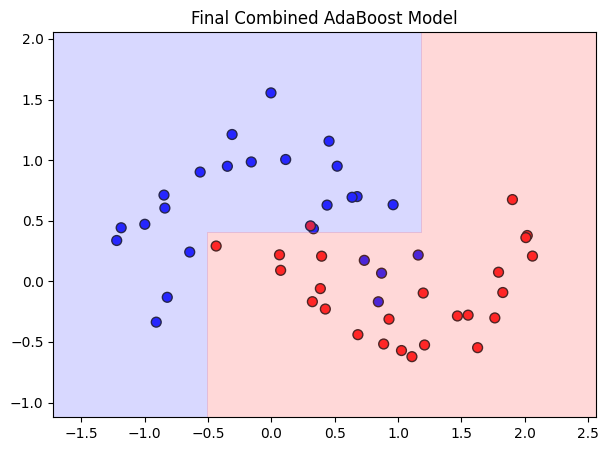

In [ ]:
# Function to get final combined prediction
def final_combined_predict(X_input, models, alphas):
    final = np.zeros(X_input.shape[0])
    for i, model in enumerate(models):
        pred = model.predict(X_input)
        pred_signed = np.where(pred == 0, -1, 1)
        final += alphas[i] * pred_signed
    return np.sign(final)

# Plot final decision boundary
fig, ax = plt.subplots(figsize=(7, 5))

# Final combined prediction boundary
plot_combined_boundary(models, alphas, X, y, t=len(models)-1, ax=ax,
                       sample_weights=sample_weights,
                       title="Final Combined AdaBoost Model",
                       use_weights=False)

# Calculate and print accuracy
y_final_pred = final_combined_predict(X, models, alphas)
accuracy = np.mean(y_final_pred == y_signed)
print(f"Final AdaBoost Model Accuracy on Training Data: {accuracy * 100:.2f}%")

plt.show()

---
## Math Recap

Let:

- $h_t(x)$ be the weak learner at iteration $t$  
- $y_i \in \{-1, +1\}$ be the true label  
- $w_i$ be the weight of sample $i$  

Then:

1. Error of stump:  
   $$
   \epsilon_t = \sum_{i=1}^n w_i \cdot \mathbf{1}[h_t(x_i) \ne y_i]
   $$

2. Model weight:  
   $$
   \alpha_t = \frac{1}{2} \log\left( \frac{1 - \epsilon_t}{\epsilon_t} \right)
   $$

3. Weight update:  
   $$
   w_i \leftarrow w_i \cdot e^{-\alpha_t y_i h_t(x_i)}
   $$

4. Normalize weights:  
   $$
   w_i \leftarrow \frac{w_i}{\sum_j w_j}
   $$


---
## Summary

- AdaBoost trains weak learners sequentially and emphasizes "hard" examples  
- Sample weights increase for misclassified points, guiding future learners  
- Final prediction is a weighted vote across all weak learners  
- Visualization helps us see this adaptation clearly  